# Deep Convolutional - Realistic Image Colorization
Image colorization of grayscale to rgb directly. This is order to see the limitation of using RGB as the output when computing the loss.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image

## Import all Modules and Configure GPU

In [2]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Debug only

/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
# Initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2023-05-11 17:48:36.114230: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 17:48:36.252623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 17:48:36.252808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-11 17:48:36.255736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
tf.__version__

'2.9.1'

### Setup Result Directory

In [5]:
root_dir = "result/realistic_colorizing_lab_color_space"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [6]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize=0):
        BUFFER_SIZE = 10000
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        #ds = ds.cache(filename='/tmp/RealisticColorizing', name='RealisticColorizing')
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_train_ds)), AUTOTUNE, 256)


In [7]:
IMAGE_SIZE = (128, 128)

EPOCHS = 64

BATCH_SIZE_PER_REPLICA = 32
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

data_directory_path = "realistic-data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

IMAGE_SIZE = (128, 128, 3)

realistic-data-colorize: Found 156299 files
Found 222057 files belonging to 1 classes.
Number of batches 6940 of 32 elements


## Augment Data

In [8]:

trainAug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(
        height_factor=(-0.05, -0.10),
        width_factor=(-0.05, -0.10)),
    layers.RandomRotation(0.4)
])

def AgumentFunc(x,y):
    aX = trainAug(x)
    return (tf.image.rgb_to_grayscale(aX), aX)

# apply augmentation image transformation to prevent overfitting.
trainAugmentedDS = (
    train_images
    .map(AgumentFunc,
         num_parallel_calls=tf.data.AUTOTUNE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

#Split data into train and validation
ds_size = len(trainAugmentedDS)
train_size = int(0.8 * ds_size)
val_size = int(0.2 * ds_size)
#Split data into train and validation
train_ds = trainAugmentedDS.take(train_size)
val_ds = trainAugmentedDS.skip(train_size).take(val_size)

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_ds = train_ds.with_options(options)
# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
val_ds = val_ds.with_options(options)


## Present DataSet Examples

2023-05-11 17:49:04.985094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 131 of 256
2023-05-11 17:49:13.506354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


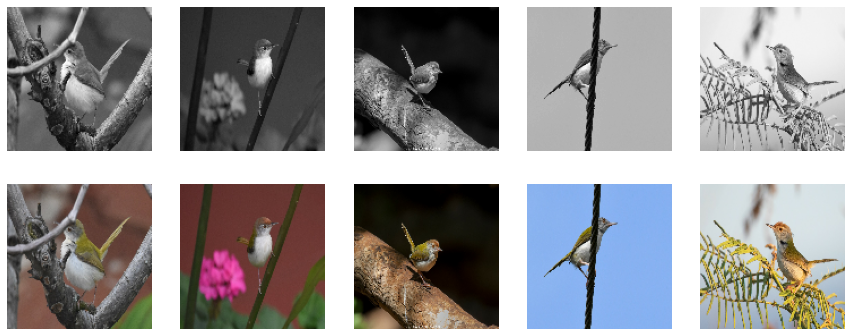

In [9]:

num_examples_to_generate = 5

bathc_iter = iter(train_images)
image_batch, expected_batch = next(bathc_iter)

plt.figure(figsize=(15, 6))
for i in range(0, num_examples_to_generate):
    ax = plt.subplot(2, num_examples_to_generate, i + 1)
    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((tf.image.rgb_to_grayscale(trainImage[:, :, :]).numpy().astype(dtype='float32') + 1.0) / 2.0, cmap='gray')
    plt.axis("off")
    ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
    # Transform pixel values from [-1,1] to [0,1]
    plt.imshow((expectedImage[:, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
    plt.axis("off")
    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.show()


### Augmented DataSet Example

2023-05-11 17:49:26.604871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 169 of 256
2023-05-11 17:49:31.540447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


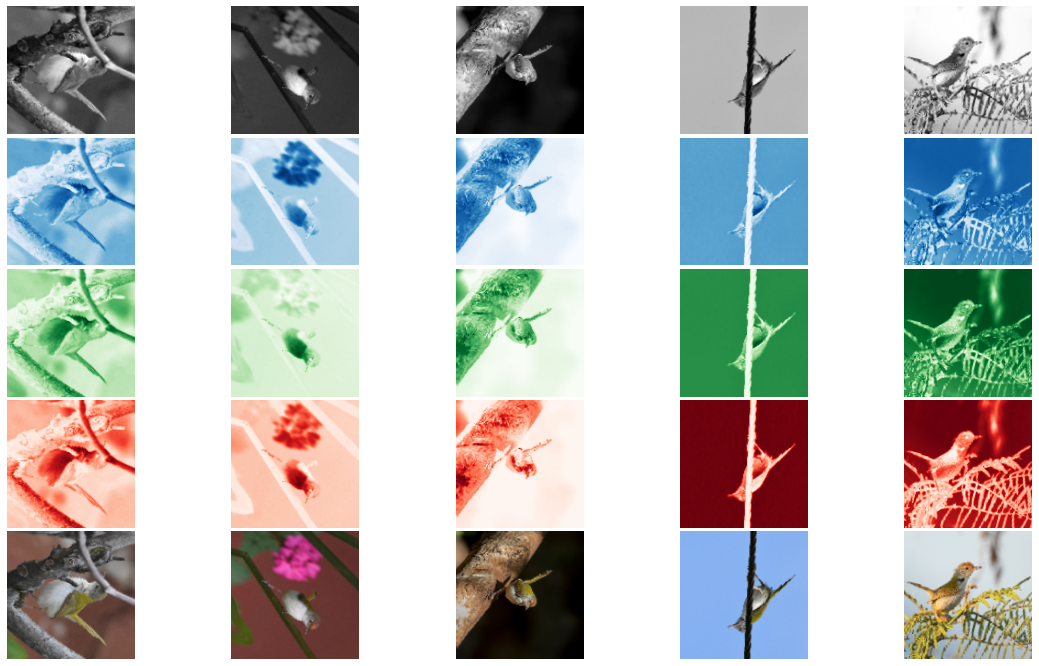

In [10]:
num_examples_to_generate = 9

bathc_iter = iter(train_ds)
image_batch, expected_batch = next(bathc_iter)

nrCol = 5
plt.figure(figsize=(10 * 2, 12))
for i in range(0, 5):

    trainImage, expectedImage = (image_batch[i % len(image_batch)], expected_batch[i % len(expected_batch)])  # (images + 1.0) / 2.0

    # Transform pixel values from [-1,1] to [0,1]
    trainImage = (trainImage + 1.0) / 2.0
    expectedImage = (expectedImage + 1.0) / 2.0

    ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
    plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
    plt.imshow(expectedImage[:, :, 0].numpy().astype(dtype='float32'), cmap='Blues')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
    plt.imshow(expectedImage[:, :, 1].numpy().astype(dtype='float32'), cmap='Greens')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
    plt.imshow(expectedImage[:, :, 2].numpy().astype(dtype='float32'), cmap='Reds')
    plt.axis("off")

    ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
    plt.imshow(expectedImage[:, :, :])
    plt.axis("off")

    if len(image_batch) - 1 == i:
        image_batch, expected_batch = next(bathc_iter)
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [11]:
def create_model(hp, input_shape,image_output_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(image_output_shape[2], (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    mse_magnitude = hp.Float('mse_magnitude', 0, 1.0, step=0.1, default=0.0)
    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    def ssim_loss(y_true, y_pred):
        return 1.0 * (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))) + mse_magnitude * tf.keras.losses.mean_squared_error(y_true, y_pred)

    model.compile(optimizer=hp_optimizer,
                  loss=ssim_loss,
                  metrics=[ssim_loss,'accuracy'])

    return model


## Hyperparameter

In [12]:

image_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
image_output_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)


def model_builder(hp):
    with strategy.scope():
        model = create_model(hp, image_input_shape, image_output_shape)
        return model


best_models = None
model = None

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='{0}/cache'.format(root_dir),
                     project_name=str.format('Colorizing - GrayScale Input - {0}', "Realistic"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5)
tuner.search(train_ds.take(1000), epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early, tf.keras.callbacks.TerminateOnNaN()], validation_data=train_ds.skip(1000).take(250), verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


Trial 13 Complete [00h 36m 32s]
val_accuracy: 0.39262261986732483

Best val_accuracy So Far: 0.5546228289604187
Total elapsed time: 04h 23m 02s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 re_lu_9 (ReLU)              (None, 128, 128, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 re_lu_10 (ReLU)             (None, 64, 64, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 re_

In [13]:
def showResult(model, batchImage):
    maxNumImages = 5

    # TODO fix
    pred = (model.predict(batchImage) + 1.0) / 2.0

    train_batch_iter = iter(batchImage)
    train_image_batch, _ = next(train_batch_iter)

    predict_batch_iter = iter(pred)

    nrCol = 5
    fig = plt.figure(figsize=(maxNumImages * 4, maxNumImages*2))

    for i in range(0, 5):

        trainImage = train_image_batch[i % len(train_image_batch)]  # (images + 1.0) / 2.0
        expectedImage = next(predict_batch_iter)

        # Transform pixel values from [-1,1] to [0,1]
        trainImage = (trainImage + 1.0) / 2.0

        ax = plt.subplot(5, nrCol, nrCol * 0 + i + 1)
        plt.imshow(trainImage[:, :, :].numpy().astype(dtype='float32'), cmap='gray')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 1 + i + 1)
        plt.imshow(expectedImage[:, :, 0].astype(dtype='float32'), cmap='Blues')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 2 + i + 1)
        plt.imshow(expectedImage[:, :, 1].astype(dtype='float32'), cmap='Greens')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 3 + i + 1)
        plt.imshow(expectedImage[:, :, 2].astype(dtype='float32'), cmap='Reds')
        plt.axis("off")

        ax = plt.subplot(5, nrCol, nrCol * 4 + i + 1)
        plt.imshow(expectedImage[:, :, :].astype(dtype='float32'))
        plt.axis("off")

        if len(train_image_batch) - 1 == i:
            train_image_batch, _ = next(train_batch_iter)
    plt.subplots_adjust(wspace=0.025, hspace=0.025)

    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)

        def ColorizeFunc(x, y):
            return (tf.image.rgb_to_grayscale(x), y)

        self.trainData = trainData.map(ColorizeFunc,
                                       num_parallel_calls=tf.data.AUTOTUNE)
        # Setup to support multiple GPUs
        options = tf.data.Options()
        options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
        self.trainData = self.trainData.with_options(options)

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("{0}/realistic_coloring_rgb_colorspace_epoch_{1}.png".format(root_dir, epoch))
        plt.close()


## Train the Final Select Model

In [14]:


model_history = {}

checkpoint_path = "{0}/checkpoints/cp.ckpt".format(root_dir)
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_ds,
                          epochs=EPOCHS,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/64


2023-05-11 22:13:02.517996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 154 of 256
2023-05-11 22:13:08.831608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 8:39 - loss: 0.9888 - ssim_loss: 0.9888 - accuracy: 0.4114

2023-05-11 22:13:23.266466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 8:38 - loss: 0.9888 - ssim_loss: 0.9888 - accuracy: 0.4113

2023-05-11 22:13:23.730640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:23.788663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 8:36 - loss: 0.9877 - ssim_loss: 0.9877 - accuracy: 0.4081

2023-05-11 22:13:24.250900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:34 - loss: 0.9888 - ssim_loss: 0.9888 - accuracy: 0.4067

2023-05-11 22:13:25.345795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.362380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.372183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.377620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 8:35 - loss: 0.9881 - ssim_loss: 0.9881 - accuracy: 0.4049

2023-05-11 22:13:25.719317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.723321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.732125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:25.733755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:37 - loss: 0.9905 - ssim_loss: 0.9905 - accuracy: 0.4036

2023-05-11 22:13:35.532417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:35.550913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:34 - loss: 0.9899 - ssim_loss: 0.9899 - accuracy: 0.4038

2023-05-11 22:13:36.418887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:36.419327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:25 - loss: 0.9878 - ssim_loss: 0.9878 - accuracy: 0.4084

2023-05-11 22:13:38.734942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:13:38.737493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9742 - ssim_loss: 0.9742 - accuracy: 0.5239

2023-05-11 22:19:03.962617: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 256


1/1 [==============================] - 18s 18s/step


2023-05-11 22:19:10.527555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:19:20.703934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 22:19:27.012362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 402s 69ms/step - loss: 0.9742 - ssim_loss: 0.9742 - accuracy: 0.5239
Epoch 2/64


2023-05-11 22:19:41.701005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 22:19:48.343784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 151/5552 [..............................] - ETA: 8:20 - loss: 0.9549 - ssim_loss: 0.9549 - accuracy: 0.4115

2023-05-11 22:20:02.747569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 8:18 - loss: 0.9557 - ssim_loss: 0.9557 - accuracy: 0.4099

2023-05-11 22:20:02.958237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 8:17 - loss: 0.9556 - ssim_loss: 0.9556 - accuracy: 0.4084

2023-05-11 22:20:03.221766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:03.360276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 8:13 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4050

2023-05-11 22:20:04.969229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.969991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.971771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.979442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.981064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.982483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.983630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:04.992945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:33 - loss: 0.9553 - ssim_loss: 0.9553 - accuracy: 0.4030

2023-05-11 22:20:14.621872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:14.727028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:29 - loss: 0.9555 - ssim_loss: 0.9555 - accuracy: 0.4036

2023-05-11 22:20:15.415776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:15.540369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:21 - loss: 0.9547 - ssim_loss: 0.9547 - accuracy: 0.4083

2023-05-11 22:20:17.754914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:20:17.899956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9786 - ssim_loss: 0.9786 - accuracy: 0.5239

2023-05-11 22:25:37.197929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:25:43.607354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:25:53.873462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 154 of 256
2023-05-11 22:26:00.445938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 393s 68ms/step - loss: 0.9786 - ssim_loss: 0.9786 - accuracy: 0.5239
Epoch 3/64


2023-05-11 22:26:14.780401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256
2023-05-11 22:26:20.929098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 8:57 - loss: 0.9553 - ssim_loss: 0.9553 - accuracy: 0.4113

2023-05-11 22:26:35.675019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 149/5552 [..............................] - ETA: 8:54 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4108

2023-05-11 22:26:35.872469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 8:53 - loss: 0.9547 - ssim_loss: 0.9547 - accuracy: 0.4112

2023-05-11 22:26:36.123845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 8:52 - loss: 0.9555 - ssim_loss: 0.9555 - accuracy: 0.4095

2023-05-11 22:26:36.375409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:50 - loss: 0.9551 - ssim_loss: 0.9551 - accuracy: 0.4067

2023-05-11 22:26:37.697925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.724302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.747545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.759066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.854480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.858213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.860843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:37.872425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:46 - loss: 0.9553 - ssim_loss: 0.9553 - accuracy: 0.4037

2023-05-11 22:26:47.997046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:48.021237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:41 - loss: 0.9553 - ssim_loss: 0.9553 - accuracy: 0.4040

2023-05-11 22:26:48.727679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:48.742460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:31 - loss: 0.9546 - ssim_loss: 0.9546 - accuracy: 0.4086

2023-05-11 22:26:51.039784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:26:51.042264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9785 - ssim_loss: 0.9785 - accuracy: 0.5240

2023-05-11 22:32:10.603153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 154 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:32:17.500110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:32:27.790236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 22:32:34.084974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 394s 68ms/step - loss: 0.9785 - ssim_loss: 0.9785 - accuracy: 0.5240
Epoch 4/64


2023-05-11 22:32:48.628611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 22:32:55.214245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 142/5552 [..............................] - ETA: 9:10 - loss: 0.9554 - ssim_loss: 0.9554 - accuracy: 0.4125

2023-05-11 22:33:09.796925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 147/5552 [..............................] - ETA: 9:08 - loss: 0.9553 - ssim_loss: 0.9553 - accuracy: 0.4110

2023-05-11 22:33:10.234554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:10.267752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 9:09 - loss: 0.9546 - ssim_loss: 0.9546 - accuracy: 0.4113

2023-05-11 22:33:10.677226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:59 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4065

2023-05-11 22:33:12.034463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.034987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.042850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.043358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.150349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.182275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.186916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:12.187935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:55 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4031

2023-05-11 22:33:22.522328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:22.633122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:52 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4037

2023-05-11 22:33:23.363718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:23.510944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:43 - loss: 0.9544 - ssim_loss: 0.9544 - accuracy: 0.4084

2023-05-11 22:33:25.787549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:33:25.940386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9785 - ssim_loss: 0.9785 - accuracy: 0.5240

2023-05-11 22:38:46.865391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:38:53.620499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:39:03.800432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 22:39:10.010490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 392s 68ms/step - loss: 0.9785 - ssim_loss: 0.9785 - accuracy: 0.5240
Epoch 5/64


2023-05-11 22:39:21.308941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 22:39:27.845206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 148/5552 [..............................] - ETA: 8:51 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4107

2023-05-11 22:39:42.536088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 8:50 - loss: 0.9545 - ssim_loss: 0.9545 - accuracy: 0.4114

2023-05-11 22:39:42.822246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 22:39:42.944896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 156/5552 [..............................] - ETA: 8:48 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4094

2023-05-11 22:39:43.273436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 8:43 - loss: 0.9551 - ssim_loss: 0.9551 - accuracy: 0.4051

2023-05-11 22:39:44.670234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.671254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.672021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.672286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.808973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.818193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.826810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:44.838166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 305/5552 [>.............................] - ETA: 7:40 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4036

2023-05-11 22:39:54.821830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:54.833994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 316/5552 [>.............................] - ETA: 7:37 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4046

2023-05-11 22:39:55.648674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:55.699529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 348/5552 [>.............................] - ETA: 7:27 - loss: 0.9548 - ssim_loss: 0.9548 - accuracy: 0.4089

2023-05-11 22:39:58.000469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:39:58.035715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9784 - ssim_loss: 0.9784 - accuracy: 0.5240

2023-05-11 22:45:17.117393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:45:23.506865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:45:33.654124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 22:45:40.016664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 392s 67ms/step - loss: 0.9784 - ssim_loss: 0.9784 - accuracy: 0.5240
Epoch 6/64


2023-05-11 22:45:53.144655: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 256
2023-05-11 22:46:00.199830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 8:43 - loss: 0.9546 - ssim_loss: 0.9546 - accuracy: 0.4112

2023-05-11 22:46:15.073478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 22:46:15.096732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 8:43 - loss: 0.9554 - ssim_loss: 0.9554 - accuracy: 0.4098

2023-05-11 22:46:15.539239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:15.566242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 170/5552 [..............................] - ETA: 8:41 - loss: 0.9551 - ssim_loss: 0.9551 - accuracy: 0.4053

2023-05-11 22:46:17.072001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.074077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.075288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.091889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.180377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.188823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.195431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:17.195979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:44 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4037

2023-05-11 22:46:27.278164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:27.303943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 312/5552 [>.............................] - ETA: 7:41 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4039

2023-05-11 22:46:28.071800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:28.101935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:32 - loss: 0.9545 - ssim_loss: 0.9545 - accuracy: 0.4084

2023-05-11 22:46:30.543072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:46:30.546894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9784 - ssim_loss: 0.9784 - accuracy: 0.5240

2023-05-11 22:51:49.557621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:51:56.201479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:52:06.499903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 153 of 256
2023-05-11 22:52:13.244236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 391s 67ms/step - loss: 0.9784 - ssim_loss: 0.9784 - accuracy: 0.5240
Epoch 7/64


2023-05-11 22:52:24.421389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256
2023-05-11 22:52:30.669150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 147/5552 [..............................] - ETA: 8:39 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4112

2023-05-11 22:52:45.080012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 152/5552 [..............................] - ETA: 8:38 - loss: 0.9547 - ssim_loss: 0.9547 - accuracy: 0.4109

2023-05-11 22:52:45.516450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 156/5552 [..............................] - ETA: 8:37 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4094

2023-05-11 22:52:45.875334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 162/5552 [..............................] - ETA: 8:34 - loss: 0.9555 - ssim_loss: 0.9555 - accuracy: 0.4072

2023-05-11 22:52:46.372636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 170/5552 [..............................] - ETA: 8:31 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4054

2023-05-11 22:52:47.097164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:47.098751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:47.115621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:47.130482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 181/5552 [..............................] - ETA: 8:28 - loss: 0.9542 - ssim_loss: 0.9542 - accuracy: 0.4044

2023-05-11 22:52:48.079877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:48.082828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:48.084798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:48.092002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:44 - loss: 0.9550 - ssim_loss: 0.9550 - accuracy: 0.4032

2023-05-11 22:52:57.388780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:57.524288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:41 - loss: 0.9552 - ssim_loss: 0.9552 - accuracy: 0.4038

2023-05-11 22:52:58.246642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:52:58.434448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:33 - loss: 0.9544 - ssim_loss: 0.9544 - accuracy: 0.4085

2023-05-11 22:53:00.782146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:53:00.907164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9676 - ssim_loss: 0.9676 - accuracy: 0.3988

2023-05-11 22:58:21.206769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 22:58:27.561157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 22:58:37.705869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 22:58:43.826029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9676 - ssim_loss: 0.9676 - accuracy: 0.3988
Epoch 8/64


2023-05-11 22:58:55.024409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 22:59:01.459358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 8:36 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3980

2023-05-11 22:59:16.067008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 22:59:16.096119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 8:36 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3989

2023-05-11 22:59:16.480466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:16.631188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 8:33 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3998

2023-05-11 22:59:18.104682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.106419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.107566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.109212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.125261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.129739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.141429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:18.192466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 7:36 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3884

2023-05-11 22:59:27.970464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:28.012351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:33 - loss: 0.9630 - ssim_loss: 0.9630 - accuracy: 0.3865

2023-05-11 22:59:28.797359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:28.808472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 344/5552 [>.............................] - ETA: 7:23 - loss: 0.9648 - ssim_loss: 0.9648 - accuracy: 0.3808

2023-05-11 22:59:31.082359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 22:59:31.083897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9936 - ssim_loss: 0.9936 - accuracy: 0.2252

2023-05-11 23:04:50.259274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 159 of 256


1/1 [==============================] - 16s 16s/step


2023-05-11 23:04:56.356876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:05:06.545401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 23:05:12.804173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 392s 68ms/step - loss: 0.9936 - ssim_loss: 0.9936 - accuracy: 0.2252
Epoch 9/64


2023-05-11 23:05:28.034180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 23:05:34.375320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 147/5552 [..............................] - ETA: 8:43 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-11 23:05:48.791331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:05:48.831786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 153/5552 [..............................] - ETA: 8:41 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3981

2023-05-11 23:05:49.252450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:49.319684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:40 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3996

2023-05-11 23:05:50.754353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.756841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.758157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.758774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.943332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 8:39 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4006

2023-05-11 23:05:50.971711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.993867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:05:50.996614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 296/5552 [>.............................] - ETA: 7:43 - loss: 0.9620 - ssim_loss: 0.9620 - accuracy: 0.3898

2023-05-11 23:06:00.590044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:06:00.697255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 307/5552 [>.............................] - ETA: 7:39 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3882

2023-05-11 23:06:01.402387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:06:01.525989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 339/5552 [>.............................] - ETA: 7:30 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3822

2023-05-11 23:06:03.734951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:06:03.889127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-11 23:11:22.965940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 159 of 256


1/1 [==============================] - 16s 16s/step


2023-05-11 23:11:29.171763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:11:39.315523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 23:11:45.784381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 10/64


2023-05-11 23:11:57.162173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 256
2023-05-11 23:12:03.994312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 145/5552 [..............................] - ETA: 8:52 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3976

2023-05-11 23:12:18.759103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 149/5552 [..............................] - ETA: 8:52 - loss: 0.9559 - ssim_loss: 0.9559 - accuracy: 0.3986

2023-05-11 23:12:19.103332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:12:19.255445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 8:51 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3995

2023-05-11 23:12:19.620943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:49 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3999

2023-05-11 23:12:20.878181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:20.880302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:20.881271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:20.889374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 170/5552 [..............................] - ETA: 8:48 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4006

2023-05-11 23:12:21.153620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:21.156394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:21.161808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:21.163768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:47 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3887

2023-05-11 23:12:31.312845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:31.324998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:43 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-11 23:12:32.137274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:32.145695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:35 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3805

2023-05-11 23:12:34.574593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:12:34.579051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-11 23:17:53.293013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 23:17:59.771079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:18:09.959661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 23:18:16.383762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 11/64


2023-05-11 23:18:27.826272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 23:18:34.253501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 152/5552 [..............................] - ETA: 8:31 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3996

2023-05-11 23:18:48.844311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 8:31 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3991

2023-05-11 23:18:49.182091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:18:49.321059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 160/5552 [..............................] - ETA: 8:32 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3976

2023-05-11 23:18:49.677349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 8:30 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.4004

2023-05-11 23:18:51.013398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.025526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.028392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.040727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 178/5552 [..............................] - ETA: 8:29 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4002

2023-05-11 23:18:51.328202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.349407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.351318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:18:51.355394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:47 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3894

2023-05-11 23:19:01.172812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:19:01.293688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:43 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3881

2023-05-11 23:19:01.975346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:19:02.117811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:35 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3813

2023-05-11 23:19:04.428855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:19:04.559622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-11 23:24:22.625399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 153 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 23:24:29.395646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:24:39.566900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 23:24:45.990262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 12/64


2023-05-11 23:24:57.421714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 23:25:03.928981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 8:41 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3989

2023-05-11 23:25:18.460216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:25:18.616445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 8:42 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3988

2023-05-11 23:25:18.918715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:19.113174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 8:37 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4002

2023-05-11 23:25:20.577466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.581670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.597419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.599937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.601276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.608450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.627566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:20.632172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 299/5552 [>.............................] - ETA: 7:40 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3889

2023-05-11 23:25:30.611054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:30.794300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 310/5552 [>.............................] - ETA: 7:37 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-11 23:25:31.432400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:31.609511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:30 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3810

2023-05-11 23:25:34.033144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:25:34.166702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-11 23:30:53.415401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 23:30:59.710672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:31:09.880282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 23:31:16.184382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 13/64


2023-05-11 23:31:27.287850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-11 23:31:33.482209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 8:45 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-11 23:31:48.121100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 152/5552 [..............................] - ETA: 8:45 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3993

2023-05-11 23:31:48.327092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 8:43 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3988

2023-05-11 23:31:48.560540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:48.770708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 8:36 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3997

2023-05-11 23:31:50.177222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.189508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.213776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.216716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.253539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.257739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.258772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:31:50.263970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:46 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3885

2023-05-11 23:32:00.338012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:32:00.363535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:43 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3869

2023-05-11 23:32:01.193144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:32:01.207109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:35 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3804

2023-05-11 23:32:03.698505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:32:03.708900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-11 23:37:22.006577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256


1/1 [==============================] - 16s 16s/step


2023-05-11 23:37:28.295058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:37:38.626340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 154 of 256
2023-05-11 23:37:45.118765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 392s 68ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 14/64


2023-05-11 23:37:59.154280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 256
2023-05-11 23:38:05.931042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 8:48 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3992

2023-05-11 23:38:20.624961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 8:46 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3991

2023-05-11 23:38:21.062598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:21.135955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 8:47 - loss: 0.9567 - ssim_loss: 0.9567 - accuracy: 0.3987

2023-05-11 23:38:21.563771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:45 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3996

2023-05-11 23:38:22.731699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:22.757081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:22.766654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:22.790377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 8:45 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4005

2023-05-11 23:38:23.166780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:23.167671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:23.168214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:23.173652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 7:51 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-11 23:38:33.082065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:33.116436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 7:48 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3885

2023-05-11 23:38:33.934965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:33.939558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 7:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3817

2023-05-11 23:38:36.419487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:38:36.472628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-11 23:43:53.491469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 23:43:59.892867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:44:10.084977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 153 of 256
2023-05-11 23:44:16.698650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 15/64


2023-05-11 23:44:28.113213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256
2023-05-11 23:44:34.405566: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 8:52 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3992

2023-05-11 23:44:48.830528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 8:50 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-11 23:44:49.171957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:44:49.347732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 8:48 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3994

2023-05-11 23:44:49.556355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 8:46 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4003

2023-05-11 23:44:50.957363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:50.963578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:50.963736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:50.975600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 8:47 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4005

2023-05-11 23:44:51.195024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:51.205132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:51.215440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:44:51.249310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:45 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3894

2023-05-11 23:45:01.016854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:45:01.162257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 310/5552 [>.............................] - ETA: 7:41 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3883

2023-05-11 23:45:01.783867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:41 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3870

2023-05-11 23:45:01.988112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 342/5552 [>.............................] - ETA: 7:35 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3819

2023-05-11 23:45:04.305914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:45:04.487409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-11 23:50:23.219769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 158 of 256


1/1 [==============================] - 16s 16s/step


2023-05-11 23:50:29.436736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:50:39.612652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 23:50:46.097278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 16/64


2023-05-11 23:50:57.364952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256
2023-05-11 23:51:04.100455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 145/5552 [..............................] - ETA: 8:37 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3975

2023-05-11 23:51:18.273458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 149/5552 [..............................] - ETA: 8:38 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3985

2023-05-11 23:51:18.689485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 153/5552 [..............................] - ETA: 8:37 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3981

2023-05-11 23:51:19.050295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 8:38 - loss: 0.9569 - ssim_loss: 0.9569 - accuracy: 0.3983

2023-05-11 23:51:19.502062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 8:32 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4003

2023-05-11 23:51:20.498594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.501005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.501550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.501892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 8:31 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-11 23:51:20.931148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.932606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.933929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:20.942218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 304/5552 [>.............................] - ETA: 7:36 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3885

2023-05-11 23:51:30.800451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:30.814962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 315/5552 [>.............................] - ETA: 7:33 - loss: 0.9628 - ssim_loss: 0.9628 - accuracy: 0.3867

2023-05-11 23:51:31.648835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:31.687010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 346/5552 [>.............................] - ETA: 7:25 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3804

2023-05-11 23:51:34.016438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:51:34.040957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-11 23:56:51.991428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256


1/1 [==============================] - 17s 17s/step


2023-05-11 23:56:58.667388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-11 23:57:09.111913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-11 23:57:15.591804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 17/64


2023-05-11 23:57:26.830413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-11 23:57:33.438643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 142/5552 [..............................] - ETA: 9:00 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3972

2023-05-11 23:57:47.940112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-11 23:57:48.082135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 146/5552 [..............................] - ETA: 9:02 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3992

2023-05-11 23:57:48.404595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:48.549898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 165/5552 [..............................] - ETA: 8:55 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3990

2023-05-11 23:57:50.200951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.204513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.207212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.212994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.216731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.216967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.217116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:57:50.217515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:46 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3894

2023-05-11 23:58:00.394398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:58:00.395593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 310/5552 [>.............................] - ETA: 7:44 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3883

2023-05-11 23:58:01.218390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:58:01.243312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 342/5552 [>.............................] - ETA: 7:34 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3819

2023-05-11 23:58:03.603070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-11 23:58:03.603891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 00:03:21.431786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 160 of 256


1/1 [==============================] - 16s 16s/step


2023-05-12 00:03:27.519504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:03:37.837318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-12 00:03:44.072452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 388s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 18/64


2023-05-12 00:03:55.242670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 149 of 256
2023-05-12 00:04:01.990391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 143/5552 [..............................] - ETA: 9:06 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3959

2023-05-12 00:04:16.559949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 147/5552 [..............................] - ETA: 9:03 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-12 00:04:16.904462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:04:17.052638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 152/5552 [..............................] - ETA: 9:00 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 00:04:17.329235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:53 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3997

2023-05-12 00:04:18.745300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.754598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.758933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.761813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.852271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.855653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.858873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:18.858974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 299/5552 [>.............................] - ETA: 7:42 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3892

2023-05-12 00:04:28.517358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:28.713702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:39 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 00:04:29.383930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:29.526262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 342/5552 [>.............................] - ETA: 7:30 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3818

2023-05-12 00:04:31.717079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:04:31.858567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:09:48.405646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 16s 16s/step


2023-05-12 00:09:54.643041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:10:04.814853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-12 00:10:11.253653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 19/64


2023-05-12 00:10:25.696991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-12 00:10:32.101769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 142/5552 [..............................] - ETA: 8:46 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3972

2023-05-12 00:10:46.139872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 147/5552 [..............................] - ETA: 8:44 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3985

2023-05-12 00:10:46.590021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 151/5552 [..............................] - ETA: 8:42 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3991

2023-05-12 00:10:46.941498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 8:41 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3990

2023-05-12 00:10:47.339186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:36 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.4000

2023-05-12 00:10:48.346880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.349343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.356528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.361200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 8:32 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3999

2023-05-12 00:10:48.829530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.842076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.851447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:48.869572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:37 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3886

2023-05-12 00:10:58.626360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:58.658748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:36 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-12 00:10:59.527707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:10:59.537982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 344/5552 [>.............................] - ETA: 7:27 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3810

2023-05-12 00:11:01.896847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:11:01.904824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:16:21.035750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256


1/1 [==============================] - 17s 17s/step


2023-05-12 00:16:28.128635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:16:38.340830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-12 00:16:44.760995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 414s 72ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 20/64


2023-05-12 00:17:19.697418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 152 of 256
2023-05-12 00:17:26.378584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 139/5552 [..............................] - ETA: 9:01 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3953

2023-05-12 00:17:40.596250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 145/5552 [..............................] - ETA: 8:57 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3972

2023-05-12 00:17:41.114913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:17:41.172132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 149/5552 [..............................] - ETA: 8:55 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3982

2023-05-12 00:17:41.484450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 8:41 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.3999

2023-05-12 00:17:43.053352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.054452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.055690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.057328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.057900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.062686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.062951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:43.074543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 304/5552 [>.............................] - ETA: 7:40 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3884

2023-05-12 00:17:53.302797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:53.312082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 315/5552 [>.............................] - ETA: 7:36 - loss: 0.9629 - ssim_loss: 0.9629 - accuracy: 0.3867

2023-05-12 00:17:54.109717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:54.120078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 347/5552 [>.............................] - ETA: 7:27 - loss: 0.9647 - ssim_loss: 0.9647 - accuracy: 0.3800

2023-05-12 00:17:56.469269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:17:56.469474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:23:15.947217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256


1/1 [==============================] - 16s 16s/step


2023-05-12 00:23:22.194859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:23:32.461403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256
2023-05-12 00:23:39.112961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 391s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 21/64


2023-05-12 00:23:50.437591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 154 of 256
2023-05-12 00:23:57.054641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 142/5552 [..............................] - ETA: 8:48 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3971

2023-05-12 00:24:11.303447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:24:11.458842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 146/5552 [..............................] - ETA: 8:48 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3991

2023-05-12 00:24:11.771554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:11.934751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 166/5552 [..............................] - ETA: 8:38 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3995

2023-05-12 00:24:13.438871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.439479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.449152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.453944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.569956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.571558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.575428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:13.579927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:36 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 00:24:23.548822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:23.731773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 310/5552 [>.............................] - ETA: 7:33 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3882

2023-05-12 00:24:24.355099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:24.536345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 7:24 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3812

2023-05-12 00:24:26.791426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:24:26.893374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 00:29:43.168705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256


1/1 [==============================] - 17s 17s/step


2023-05-12 00:29:49.626654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:29:59.909705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 152 of 256
2023-05-12 00:30:06.796606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 22/64


2023-05-12 00:30:20.895524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-12 00:30:27.322412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 144/5552 [..............................] - ETA: 8:47 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3960

2023-05-12 00:30:41.534577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 149/5552 [..............................] - ETA: 8:46 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3985

2023-05-12 00:30:41.995393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 151/5552 [..............................] - ETA: 8:46 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3990

2023-05-12 00:30:42.255377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 8:46 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3986

2023-05-12 00:30:42.704630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:42 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3998

2023-05-12 00:30:43.719556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:43.729105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:43.739843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:43.780636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 8:38 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.3997

2023-05-12 00:30:44.199244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:44.204324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:44.206581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:44.214672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 7:50 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 00:30:54.334662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:54.491604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 7:46 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 00:30:55.178244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:55.333933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 342/5552 [>.............................] - ETA: 7:38 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3817

2023-05-12 00:30:57.606911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:30:57.761856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:36:15.030595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256


1/1 [==============================] - 17s 17s/step


2023-05-12 00:36:21.244403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:36:31.478383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 155 of 256
2023-05-12 00:36:38.003943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 388s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 23/64


2023-05-12 00:36:49.337828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 157 of 256
2023-05-12 00:36:55.476750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 144/5552 [..............................] - ETA: 8:48 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3956

2023-05-12 00:37:09.775704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 147/5552 [..............................] - ETA: 8:47 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3981

2023-05-12 00:37:10.111591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:37:10.221473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 152/5552 [..............................] - ETA: 8:44 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3991

2023-05-12 00:37:10.540204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:37 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3996

2023-05-12 00:37:11.813740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:11.821167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:11.826658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:11.862636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 170/5552 [..............................] - ETA: 8:36 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4002

2023-05-12 00:37:12.101442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:12.107986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:12.114380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:12.141820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:40 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3884

2023-05-12 00:37:22.198835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:22.349883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:36 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3869

2023-05-12 00:37:22.965014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:23.115745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:27 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3803

2023-05-12 00:37:25.365768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:37:25.494646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 00:42:44.016204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 149 of 256


1/1 [==============================] - 17s 17s/step


2023-05-12 00:42:50.883136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:43:01.119412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 150 of 256
2023-05-12 00:43:07.856598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 390s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 24/64


2023-05-12 00:43:19.311485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 151 of 256
2023-05-12 00:43:26.045424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 144/5552 [..............................] - ETA: 8:50 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3963

2023-05-12 00:43:40.325753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:43:40.442019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 8:49 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3987

2023-05-12 00:43:40.847124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:40.884810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 8:42 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.4000

2023-05-12 00:43:42.433969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.436416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.449331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.452753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.511997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.516692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.518282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:42.520036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 7:45 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3886

2023-05-12 00:43:52.919701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:52.942361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 7:42 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-12 00:43:53.842371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:53.843101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 7:34 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3805

2023-05-12 00:43:56.258899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:43:56.263585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:49:13.423648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 156 of 256


1/1 [==============================] - 17s 17s/step


2023-05-12 00:49:19.800337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:49:29.997466: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 152 of 256
2023-05-12 00:49:36.710706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 389s 67ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 25/64


2023-05-12 00:49:48.237590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 152 of 256
2023-05-12 00:49:54.913064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 145/5552 [..............................] - ETA: 8:53 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3975

2023-05-12 00:50:09.581563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 8:53 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-12 00:50:10.051434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:10.107483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 8:52 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3985

2023-05-12 00:50:10.622148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 8:50 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3995

2023-05-12 00:50:11.731228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:11.733778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:11.734707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:11.745145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 8:46 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4000

2023-05-12 00:50:12.220981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:12.234533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:12.244016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:12.252453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 7:54 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 00:50:22.079670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:22.081591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 7:50 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3885

2023-05-12 00:50:22.900586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:22.923357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 340/5552 [>.............................] - ETA: 7:41 - loss: 0.9642 - ssim_loss: 0.9642 - accuracy: 0.3823

2023-05-12 00:50:25.333251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:50:25.340293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 00:55:33.656189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 00:55:38.085889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 00:55:48.226262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 00:55:52.739365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 376s 65ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 26/64


2023-05-12 00:56:04.531542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 00:56:08.979659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 148/5552 [..............................] - ETA: 7:48 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3989

2023-05-12 00:56:22.055629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 00:56:22.191723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 7:47 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3996

2023-05-12 00:56:22.534491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:22.589548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 7:43 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4006

2023-05-12 00:56:23.967994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:23.971784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:23.989900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:23.993293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:23.994634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:23.998430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:24.000388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:24.016689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 304/5552 [>.............................] - ETA: 6:47 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3885

2023-05-12 00:56:32.803289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:32.804529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 316/5552 [>.............................] - ETA: 6:43 - loss: 0.9628 - ssim_loss: 0.9628 - accuracy: 0.3871

2023-05-12 00:56:33.533751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:33.536627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 347/5552 [>.............................] - ETA: 6:35 - loss: 0.9647 - ssim_loss: 0.9647 - accuracy: 0.3802

2023-05-12 00:56:35.563725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 00:56:35.564584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 01:01:34.343876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:01:39.128972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:01:49.339274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:01:53.805320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 27/64


2023-05-12 01:02:04.917687: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:02:09.318478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 155/5552 [..............................] - ETA: 7:29 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3990

2023-05-12 01:02:22.356692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:28 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3981

2023-05-12 01:02:22.651732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 01:02:22.812020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 163/5552 [..............................] - ETA: 7:28 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3978

2023-05-12 01:02:23.045449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:27 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 01:02:24.216967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.218103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.223923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.230005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 181/5552 [..............................] - ETA: 7:25 - loss: 0.9582 - ssim_loss: 0.9582 - accuracy: 0.3995

2023-05-12 01:02:24.460662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.463056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.522863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:24.545441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:50 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 01:02:33.027552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:33.053790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:46 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3870

2023-05-12 01:02:33.732593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:33.773641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:37 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3805

2023-05-12 01:02:35.818068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:02:35.820500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 01:07:35.426908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:07:40.013176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:07:50.208665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:07:54.701038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 361s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 28/64


2023-05-12 01:08:05.860073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:08:10.325720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 152/5552 [..............................] - ETA: 7:41 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3996

2023-05-12 01:08:23.382887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 7:41 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3991

2023-05-12 01:08:23.656816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 01:08:23.790737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 160/5552 [..............................] - ETA: 7:40 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3975

2023-05-12 01:08:24.065321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:38 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4003

2023-05-12 01:08:25.228614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.236126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.241719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.254254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:37 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3995

2023-05-12 01:08:25.476343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.491940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.519214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:25.520457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:52 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3890

2023-05-12 01:08:34.044194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:34.162481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:49 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-12 01:08:34.719340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:34.832815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:40 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3813

2023-05-12 01:08:36.754959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:08:36.879193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 01:13:35.742922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:13:40.248505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:13:50.426978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 01:13:54.981648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 29/64


2023-05-12 01:14:06.020775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 01:14:10.647731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:39 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-12 01:14:23.491425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 7:38 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 01:14:23.862315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 01:14:24.009815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 158/5552 [..............................] - ETA: 7:38 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3981

2023-05-12 01:14:24.240776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 7:36 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.3998

2023-05-12 01:14:25.447747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.454955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.469381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.475306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.649094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.649424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.650091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:25.651371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:49 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3885

2023-05-12 01:14:34.307930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:34.334620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:46 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3869

2023-05-12 01:14:35.040042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:35.043886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:37 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3803

2023-05-12 01:14:37.106401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:14:37.107357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 01:19:35.747158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:19:40.264872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:19:50.584122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:19:55.078891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 30/64


2023-05-12 01:20:06.154647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 01:20:10.797527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 148/5552 [..............................] - ETA: 7:39 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3986

2023-05-12 01:20:23.644127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 152/5552 [..............................] - ETA: 7:40 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 01:20:24.086060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:24.137483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 7:40 - loss: 0.9569 - ssim_loss: 0.9569 - accuracy: 0.3983

2023-05-12 01:20:24.570981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 7:37 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.4003

2023-05-12 01:20:25.490229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.495980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.504797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.515775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 175/5552 [..............................] - ETA: 7:34 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3989

2023-05-12 01:20:25.936438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.937017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.938906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:25.942550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 304/5552 [>.............................] - ETA: 6:45 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 01:20:34.611086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:34.623167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 315/5552 [>.............................] - ETA: 6:42 - loss: 0.9628 - ssim_loss: 0.9628 - accuracy: 0.3868

2023-05-12 01:20:35.348250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:35.365042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 347/5552 [>.............................] - ETA: 6:34 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3801

2023-05-12 01:20:37.395118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:20:37.397460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 01:25:36.409945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:25:40.931292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:25:51.101691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:25:55.594836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 31/64


2023-05-12 01:26:06.689153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256
2023-05-12 01:26:11.344060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 148/5552 [..............................] - ETA: 7:43 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3988

2023-05-12 01:26:24.279154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 01:26:24.430649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 153/5552 [..............................] - ETA: 7:43 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3982

2023-05-12 01:26:24.719548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:24.856255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 7:39 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4007

2023-05-12 01:26:26.136558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.139967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.142310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.153309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.267361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.281191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.286502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:26.295255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 296/5552 [>.............................] - ETA: 6:52 - loss: 0.9620 - ssim_loss: 0.9620 - accuracy: 0.3898

2023-05-12 01:26:34.849788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:34.971331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 307/5552 [>.............................] - ETA: 6:49 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3882

2023-05-12 01:26:35.523335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:35.666551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 339/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3821

2023-05-12 01:26:37.580129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:26:37.707438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 01:31:36.870163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:31:41.631811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:31:51.865370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256
2023-05-12 01:31:56.294340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 361s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 32/64


2023-05-12 01:32:07.382601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:32:11.864712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 149/5552 [..............................] - ETA: 7:46 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3987

2023-05-12 01:32:24.782462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 7:44 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3992

2023-05-12 01:32:25.168171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:25.331314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 161/5552 [..............................] - ETA: 7:42 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3978

2023-05-12 01:32:25.714651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 7:40 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4000

2023-05-12 01:32:26.708284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:26.711449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:26.712121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:26.717282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 178/5552 [..............................] - ETA: 7:39 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 01:32:27.149129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:27.155067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:27.156667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:27.162560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:54 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 01:32:35.724435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:35.743426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:50 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3871

2023-05-12 01:32:36.417471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:36.437248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:41 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3806

2023-05-12 01:32:38.486276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:32:38.488123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 01:37:37.933703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:37:42.546881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:37:52.750486: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:37:57.243414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 361s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 33/64


2023-05-12 01:38:08.370644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 01:38:12.911999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 148/5552 [..............................] - ETA: 7:42 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3986

2023-05-12 01:38:25.695379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 7:40 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3994

2023-05-12 01:38:26.148825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:26.213364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 160/5552 [..............................] - ETA: 7:39 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3973

2023-05-12 01:38:26.633772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 7:37 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4006

2023-05-12 01:38:27.511713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:27.521171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:27.523640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:27.525586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:36 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3999

2023-05-12 01:38:28.037322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:28.039934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:28.040907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:28.046057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 304/5552 [>.............................] - ETA: 6:47 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 01:38:36.604005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:36.616489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 315/5552 [>.............................] - ETA: 6:44 - loss: 0.9628 - ssim_loss: 0.9628 - accuracy: 0.3868

2023-05-12 01:38:37.294088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:37.327469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 347/5552 [>.............................] - ETA: 6:35 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3802

2023-05-12 01:38:39.397431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:38:39.400075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 01:43:38.528346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:43:42.936421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:43:53.094005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:43:57.576014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 34/64


2023-05-12 01:44:08.808255: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 01:44:13.279795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 145/5552 [..............................] - ETA: 7:45 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3977

2023-05-12 01:44:26.039911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 7:46 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3986

2023-05-12 01:44:26.440257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 7:44 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3996

2023-05-12 01:44:26.797637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 159/5552 [..............................] - ETA: 7:43 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3976

2023-05-12 01:44:27.201687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 7:42 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4000

2023-05-12 01:44:27.859454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:27.865594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:27.891218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:27.902097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:41 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.3993

2023-05-12 01:44:28.618396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:28.625754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:28.629174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:28.629500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 296/5552 [>.............................] - ETA: 6:55 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3897

2023-05-12 01:44:36.893961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:37.036799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 307/5552 [>.............................] - ETA: 6:51 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3881

2023-05-12 01:44:37.604446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:37.742083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 339/5552 [>.............................] - ETA: 6:42 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3820

2023-05-12 01:44:39.672416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:44:39.816228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 01:49:38.959361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:49:43.391185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:49:53.614905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:49:58.122785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 364s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 35/64


2023-05-12 01:50:12.817118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:50:17.288854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 153/5552 [..............................] - ETA: 7:39 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3984

2023-05-12 01:50:30.540453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 01:50:30.602999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:38 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3983

2023-05-12 01:50:30.970743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:30.993773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:35 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3995

2023-05-12 01:50:32.394617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.405981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.411943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.414299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.442607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.443044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.443366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:32.447305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:52 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3894

2023-05-12 01:50:41.052927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:41.206468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-12 01:50:41.789113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:41.914995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3814

2023-05-12 01:50:43.804082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:50:43.935969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 01:55:40.569530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 01:55:45.215286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 01:55:55.440083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 01:56:00.033112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 36/64


2023-05-12 01:56:11.069697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 01:56:15.713710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:35 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-12 01:56:28.404026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 7:35 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3994

2023-05-12 01:56:28.809034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 161/5552 [..............................] - ETA: 7:32 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.3974

2023-05-12 01:56:29.354928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 167/5552 [..............................] - ETA: 7:31 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3997

2023-05-12 01:56:29.795421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:31 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4004

2023-05-12 01:56:30.247310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:30.258934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:30.264001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:30.268938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 183/5552 [..............................] - ETA: 7:30 - loss: 0.9582 - ssim_loss: 0.9582 - accuracy: 0.4003

2023-05-12 01:56:31.163493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:31.172705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:31.175699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:31.180019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:52 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3892

2023-05-12 01:56:39.349537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:39.375780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 01:56:40.059119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:40.089415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:40 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3811

2023-05-12 01:56:42.125445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 01:56:42.135255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:01:40.969230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:01:45.383814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:01:55.562262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:01:59.968285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 37/64


2023-05-12 02:02:11.062541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:02:15.633928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:32 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3987

2023-05-12 02:02:28.436138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 7:31 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3988

2023-05-12 02:02:28.923261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:28.982762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 162/5552 [..............................] - ETA: 7:30 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.3975

2023-05-12 02:02:29.427056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:28 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4007

2023-05-12 02:02:30.267226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.280849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.296083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.315526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 180/5552 [..............................] - ETA: 7:28 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.4000

2023-05-12 02:02:30.871439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.884437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.894851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:30.900675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:51 - loss: 0.9620 - ssim_loss: 0.9620 - accuracy: 0.3894

2023-05-12 02:02:39.216325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:39.241907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3886

2023-05-12 02:02:39.971719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:39.976906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:39 - loss: 0.9642 - ssim_loss: 0.9642 - accuracy: 0.3819

2023-05-12 02:02:41.994200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:02:41.996923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:07:39.388173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:07:43.939490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:07:54.133015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256
2023-05-12 02:07:58.779671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 359s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 38/64


2023-05-12 02:08:09.890230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 171 of 256
2023-05-12 02:08:14.784652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 138/5552 [..............................] - ETA: 7:46 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3947

2023-05-12 02:08:26.759144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 144/5552 [..............................] - ETA: 7:43 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3957

2023-05-12 02:08:27.198369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 156/5552 [..............................] - ETA: 7:39 - loss: 0.9567 - ssim_loss: 0.9567 - accuracy: 0.3983

2023-05-12 02:08:28.193012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 161/5552 [..............................] - ETA: 7:37 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.3972

2023-05-12 02:08:28.551662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 7:36 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3996

2023-05-12 02:08:29.054357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.063463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.066140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.070215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:36 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3998

2023-05-12 02:08:29.657625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.667938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.670205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:29.688552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:44 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3882

2023-05-12 02:08:38.144345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:38.272575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:41 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3866

2023-05-12 02:08:38.883234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:39.020419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:32 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3801

2023-05-12 02:08:40.900147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:08:41.027090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:13:37.946671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:13:42.697543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:13:52.828900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 02:13:57.391803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 39/64


2023-05-12 02:14:08.554454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 02:14:13.165125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 7:53 - loss: 0.9559 - ssim_loss: 0.9559 - accuracy: 0.3991

2023-05-12 02:14:25.966740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 151/5552 [..............................] - ETA: 7:52 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3990

2023-05-12 02:14:26.421353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:26.541325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:50 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3981

2023-05-12 02:14:26.954569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 7:49 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3996

2023-05-12 02:14:27.833366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:27.843835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:27.857668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:27.885032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 175/5552 [..............................] - ETA: 7:45 - loss: 0.9578 - ssim_loss: 0.9578 - accuracy: 0.3989

2023-05-12 02:14:28.382951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:28.390490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:28.397670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:28.398305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:52 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3890

2023-05-12 02:14:36.794487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:36.903013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:49 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-12 02:14:37.491160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:37.589246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3813

2023-05-12 02:14:39.504579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:14:39.635193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 02:19:36.705411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:19:41.294452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:19:51.423240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:19:55.895840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 364s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 40/64


2023-05-12 02:20:12.216728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 02:20:16.796221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 153/5552 [..............................] - ETA: 7:29 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3983

2023-05-12 02:20:29.832591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 02:20:29.974828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 159/5552 [..............................] - ETA: 7:29 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3977

2023-05-12 02:20:30.309591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:30.364893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 175/5552 [..............................] - ETA: 7:29 - loss: 0.9578 - ssim_loss: 0.9578 - accuracy: 0.3990

2023-05-12 02:20:31.710533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.711820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.734513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.741013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.836911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.842407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.852357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:31.855879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:47 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3887

2023-05-12 02:20:40.530409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:40.547944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:44 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-12 02:20:41.252941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:41.264714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:36 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3806

2023-05-12 02:20:43.353861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:20:43.356083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:25:41.674063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:25:46.316011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:25:56.495540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:26:00.975707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 365s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 41/64


2023-05-12 02:26:17.281020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:26:21.851923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 157/5552 [..............................] - ETA: 7:26 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3985

2023-05-12 02:26:34.995593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 02:26:35.025618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 163/5552 [..............................] - ETA: 7:25 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3979

2023-05-12 02:26:35.452289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:35.487473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 180/5552 [..............................] - ETA: 7:21 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.4000

2023-05-12 02:26:36.851708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.857410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.862275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.866839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.922778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.923971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.936671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:36.959188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:49 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3887

2023-05-12 02:26:45.561697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:45.587646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:46 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-12 02:26:46.292736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:46.322683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:38 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3806

2023-05-12 02:26:48.372231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:26:48.406572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:31:47.412924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:31:52.085673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:32:02.284794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256
2023-05-12 02:32:06.670668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 366s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 42/64


2023-05-12 02:32:22.958662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:32:27.466066: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 155/5552 [..............................] - ETA: 7:35 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3992

2023-05-12 02:32:40.596815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 02:32:40.609517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 159/5552 [..............................] - ETA: 7:34 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3977

2023-05-12 02:32:40.996986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:41.062726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:33 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3994

2023-05-12 02:32:42.417829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.435650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.441347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.455742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.468138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.471301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.487699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:42.524938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:51 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 02:32:51.231993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:51.244542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:47 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3871

2023-05-12 02:32:51.913197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:51.931204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:39 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3805

2023-05-12 02:32:54.021112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:32:54.023442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:37:52.977995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:37:57.439363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:38:07.633376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256
2023-05-12 02:38:12.037050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 43/64


2023-05-12 02:38:23.094122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 02:38:27.653452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 152/5552 [..............................] - ETA: 7:34 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3993

2023-05-12 02:38:40.587210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 7:34 - loss: 0.9567 - ssim_loss: 0.9567 - accuracy: 0.3985

2023-05-12 02:38:40.908346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 02:38:40.976774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 161/5552 [..............................] - ETA: 7:33 - loss: 0.9577 - ssim_loss: 0.9577 - accuracy: 0.3974

2023-05-12 02:38:41.308985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:30 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 02:38:42.430607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.436466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.441184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.451874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 179/5552 [..............................] - ETA: 7:29 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3987

2023-05-12 02:38:42.752020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.767559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.771479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:42.775681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:51 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3893

2023-05-12 02:38:51.321944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:51.349385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:48 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3880

2023-05-12 02:38:52.036013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:52.048150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3813

2023-05-12 02:38:54.079715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:38:54.080657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 02:43:52.718278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:43:57.232384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:44:07.325154: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256
2023-05-12 02:44:12.081258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 44/64


2023-05-12 02:44:23.192088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 02:44:27.811664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 144/5552 [..............................] - ETA: 7:54 - loss: 0.9563 - ssim_loss: 0.9563 - accuracy: 0.3958

2023-05-12 02:44:40.475657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 7:52 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3983

2023-05-12 02:44:40.926493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 7:52 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3993

2023-05-12 02:44:41.283621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 159/5552 [..............................] - ETA: 7:50 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3973

2023-05-12 02:44:41.678323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 7:46 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3994

2023-05-12 02:44:42.389125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:42.401161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:42.417666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:42.426721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:44 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3998

2023-05-12 02:44:43.106415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:43.109366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:43.111244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:43.115124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:53 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3889

2023-05-12 02:44:51.483706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:51.604188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:50 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 02:44:52.165255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:52.291307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:41 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3812

2023-05-12 02:44:54.236309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:44:54.368346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 02:49:53.116628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:49:57.580043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:50:07.776501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 02:50:12.300169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 45/64


2023-05-12 02:50:23.469049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 02:50:28.149799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 151/5552 [..............................] - ETA: 7:33 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3989

2023-05-12 02:50:40.997559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 7:32 - loss: 0.9567 - ssim_loss: 0.9567 - accuracy: 0.3985

2023-05-12 02:50:41.472813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:41.571932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 162/5552 [..............................] - ETA: 7:32 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3970

2023-05-12 02:50:41.940581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 7:31 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3997

2023-05-12 02:50:42.873287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:42.877844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:42.878280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:42.893360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 179/5552 [..............................] - ETA: 7:30 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3985

2023-05-12 02:50:43.372423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:43.376783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:43.396372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:43.401155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:53 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 02:50:51.782796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:51.804196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:50 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3884

2023-05-12 02:50:52.507131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:52.538642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:41 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3817

2023-05-12 02:50:54.589706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:50:54.595066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 02:55:53.638092: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 02:55:58.048088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 02:56:08.219972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 02:56:12.738260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 364s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 46/64


2023-05-12 02:56:27.509039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 02:56:31.960931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 152/5552 [..............................] - ETA: 7:38 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3996

2023-05-12 02:56:44.961007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 7:36 - loss: 0.9569 - ssim_loss: 0.9569 - accuracy: 0.3984

2023-05-12 02:56:45.338115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:45.477067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 163/5552 [..............................] - ETA: 7:37 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3979

2023-05-12 02:56:45.902829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:34 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.4003

2023-05-12 02:56:46.766282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:46.768142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:46.769813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:46.770424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 181/5552 [..............................] - ETA: 7:34 - loss: 0.9581 - ssim_loss: 0.9581 - accuracy: 0.3995

2023-05-12 02:56:47.391758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:47.397831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:47.402499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:47.414588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:53 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 02:56:55.883573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:55.894183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:50 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3871

2023-05-12 02:56:56.567312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:56.568830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:40 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3806

2023-05-12 02:56:58.618761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 02:56:58.619966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:01:56.351111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:02:00.845314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:02:10.979290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 03:02:15.470275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 359s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 47/64


2023-05-12 03:02:26.557084: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 03:02:31.012650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:48 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-12 03:02:44.211480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 03:02:44.223121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 7:49 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3990

2023-05-12 03:02:44.625892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:44.639284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 171/5552 [..............................] - ETA: 7:46 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4006

2023-05-12 03:02:46.058509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.073768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.074309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.076317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.079248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.082614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.095113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:46.107411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:51 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3894

2023-05-12 03:02:54.677087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:54.822885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:47 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3881

2023-05-12 03:02:55.407419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:55.540078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:38 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3813

2023-05-12 03:02:57.426469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:02:57.555725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 03:07:54.904808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:07:59.304399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:08:09.435106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:08:13.936544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 48/64


2023-05-12 03:08:25.000237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 03:08:29.531088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 147/5552 [..............................] - ETA: 7:38 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-12 03:08:42.368246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 152/5552 [..............................] - ETA: 7:39 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3994

2023-05-12 03:08:42.736843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:42.916039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:38 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3980

2023-05-12 03:08:43.300793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 169/5552 [..............................] - ETA: 7:36 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.4003

2023-05-12 03:08:44.181778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.187224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.202045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.217239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:33 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3992

2023-05-12 03:08:44.720057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.729867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.760088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:44.760251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:49 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 03:08:53.214282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:53.214902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:45 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 03:08:53.943549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:53.946314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:37 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3812

2023-05-12 03:08:56.003899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:08:56.004515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 03:13:54.554251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:13:59.013992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:14:09.264677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 03:14:13.756426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 49/64


2023-05-12 03:14:24.916753: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 03:14:29.443524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 149/5552 [..............................] - ETA: 7:49 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3987

2023-05-12 03:14:42.541166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 152/5552 [..............................] - ETA: 7:48 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3995

2023-05-12 03:14:42.750245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 153/5552 [..............................] - ETA: 7:48 - loss: 0.9565 - ssim_loss: 0.9565 - accuracy: 0.3982

2023-05-12 03:14:42.958750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 156/5552 [..............................] - ETA: 7:48 - loss: 0.9567 - ssim_loss: 0.9567 - accuracy: 0.3987

2023-05-12 03:14:43.169645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:45 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4006

2023-05-12 03:14:44.518973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.520331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.529611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.545255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.552933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.562223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.565677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:44.575020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:51 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3890

2023-05-12 03:14:53.184280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:53.289590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-12 03:14:53.866130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:54.012688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3814

2023-05-12 03:14:55.886676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:14:56.015932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:19:52.738520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:19:57.118994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:20:07.219162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 03:20:11.683929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 363s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 50/64


2023-05-12 03:20:28.001102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:20:32.492300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:48 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3984

2023-05-12 03:20:45.594728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 03:20:45.771234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 7:46 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3985

2023-05-12 03:20:46.018725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:46.202872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 173/5552 [..............................] - ETA: 7:44 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.3998

2023-05-12 03:20:47.471511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.486304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.504614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.505835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.555736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.558241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.558564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:47.562387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:55 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3888

2023-05-12 03:20:56.329484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:56.335227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:52 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3877

2023-05-12 03:20:57.003943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:57.008866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:42 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3811

2023-05-12 03:20:59.075627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:20:59.076656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 03:25:56.639776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:26:00.980874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:26:11.116953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:26:15.715837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 359s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 51/64


2023-05-12 03:26:26.865203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 03:26:31.397531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 153/5552 [..............................] - ETA: 7:38 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3985

2023-05-12 03:26:44.436138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 7:37 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3993

2023-05-12 03:26:44.672748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 03:26:44.858953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 160/5552 [..............................] - ETA: 7:37 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3977

2023-05-12 03:26:45.078041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 175/5552 [..............................] - ETA: 7:36 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3992

2023-05-12 03:26:46.304836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.328151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.335419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.367153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.505778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:36 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4002

2023-05-12 03:26:46.507047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.508455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:46.510367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:57 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3896

2023-05-12 03:26:55.134299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:55.170421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:53 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3887

2023-05-12 03:26:55.841766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:55.854229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:43 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3820

2023-05-12 03:26:57.907473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:26:57.909855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 03:31:55.209019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 14s 14s/step


2023-05-12 03:31:59.539242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:32:09.753861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:32:14.534517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 359s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 52/64


2023-05-12 03:32:25.671056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 03:32:30.127609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 155/5552 [..............................] - ETA: 7:33 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3991

2023-05-12 03:32:43.300733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 03:32:43.397535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 160/5552 [..............................] - ETA: 7:32 - loss: 0.9574 - ssim_loss: 0.9574 - accuracy: 0.3975

2023-05-12 03:32:43.701633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:43.831231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:31 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 03:32:45.153695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.157407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.158336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.197103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.245209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.247160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.272186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:45.285605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:57 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3894

2023-05-12 03:32:53.994082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:53.995565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:54 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3886

2023-05-12 03:32:54.719020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:54.720054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:45 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3818

2023-05-12 03:32:56.815769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:32:56.820864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:37:56.092828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 162 of 256


1/1 [==============================] - 16s 16s/step


2023-05-12 03:38:01.910519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:38:12.083019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 03:38:16.517141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 362s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 53/64


2023-05-12 03:38:27.713952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 03:38:32.354017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 144/5552 [..............................] - ETA: 7:36 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3961

2023-05-12 03:38:44.884858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 7:34 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-12 03:38:45.334319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 154/5552 [..............................] - ETA: 7:33 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 03:38:45.665979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:34 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3981

2023-05-12 03:38:46.056031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 166/5552 [..............................] - ETA: 7:35 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3996

2023-05-12 03:38:46.725997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:46.732264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:46.732807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:46.742105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 176/5552 [..............................] - ETA: 7:32 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3993

2023-05-12 03:38:47.511558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:47.518776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:47.565862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:47.572584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 296/5552 [>.............................] - ETA: 6:46 - loss: 0.9620 - ssim_loss: 0.9620 - accuracy: 0.3898

2023-05-12 03:38:55.611951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:55.734344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 307/5552 [>.............................] - ETA: 6:42 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3882

2023-05-12 03:38:56.316293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:56.450713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 339/5552 [>.............................] - ETA: 6:34 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3821

2023-05-12 03:38:58.378959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:38:58.515694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:43:55.577634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:43:59.992143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:44:10.122242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:44:14.688805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 54/64


2023-05-12 03:44:25.849076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 03:44:30.739125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 143/5552 [..............................] - ETA: 7:47 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3964

2023-05-12 03:44:43.224375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 148/5552 [..............................] - ETA: 7:48 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3991

2023-05-12 03:44:43.657787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:43.810645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 155/5552 [..............................] - ETA: 7:47 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3994

2023-05-12 03:44:44.280575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 165/5552 [..............................] - ETA: 7:45 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3993

2023-05-12 03:44:45.125316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.128798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.131935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.133949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:42 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4009

2023-05-12 03:44:45.650988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.654625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.658177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:45.659162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:48 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3896

2023-05-12 03:44:54.052741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:54.155171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:44 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3888

2023-05-12 03:44:54.725522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:54.882508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:35 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3820

2023-05-12 03:44:56.743243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:44:56.866579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:49:53.493200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:49:58.152525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:50:08.279080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 03:50:12.753769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 363s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 55/64


2023-05-12 03:50:29.054436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 173 of 256
2023-05-12 03:50:33.704121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:38 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3984

2023-05-12 03:50:46.511591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 153/5552 [..............................] - ETA: 7:38 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3981

2023-05-12 03:50:46.746618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 03:50:46.891399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 157/5552 [..............................] - ETA: 7:38 - loss: 0.9569 - ssim_loss: 0.9569 - accuracy: 0.3983

2023-05-12 03:50:47.171018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:36 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.4004

2023-05-12 03:50:48.428526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.429430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.453696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.462950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.513790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.518013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.519652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:48.528176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:46 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3885

2023-05-12 03:50:57.185983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:57.198450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:43 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3869

2023-05-12 03:50:57.918838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:57.922779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:34 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3804

2023-05-12 03:50:59.898063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:50:59.899427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 03:55:57.445165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 03:56:01.842715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 03:56:12.037232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:56:16.668406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 359s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 56/64


2023-05-12 03:56:27.779268: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 03:56:32.370407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 146/5552 [..............................] - ETA: 7:44 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3989

2023-05-12 03:56:44.956671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 7:42 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3982

2023-05-12 03:56:45.282128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 156/5552 [..............................] - ETA: 7:40 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3984

2023-05-12 03:56:45.809883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 161/5552 [..............................] - ETA: 7:40 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3973

2023-05-12 03:56:46.211615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 168/5552 [..............................] - ETA: 7:38 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3994

2023-05-12 03:56:46.788826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:46.793995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:46.794328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:46.852312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 179/5552 [..............................] - ETA: 7:36 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3985

2023-05-12 03:56:47.686474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:47.688708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:47.694036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:47.697277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:49 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3892

2023-05-12 03:56:55.830303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:55.959984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:45 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3878

2023-05-12 03:56:56.532173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:56.687996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:37 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3812

2023-05-12 03:56:58.573350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 03:56:58.718631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 04:01:54.916755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:01:59.356058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:02:09.540214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:02:14.016710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 357s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 57/64


2023-05-12 04:02:25.061588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 04:02:29.540717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 154/5552 [..............................] - ETA: 7:31 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 04:02:42.550257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:31 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3981

2023-05-12 04:02:42.930011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:02:42.974463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 164/5552 [..............................] - ETA: 7:29 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3988

2023-05-12 04:02:43.382464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:30 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4000

2023-05-12 04:02:44.520780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.534609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.543889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.566861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 180/5552 [..............................] - ETA: 7:29 - loss: 0.9578 - ssim_loss: 0.9578 - accuracy: 0.4000

2023-05-12 04:02:44.745037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.751912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.754614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:44.770178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:51 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3893

2023-05-12 04:02:53.188940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:53.307873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3879

2023-05-12 04:02:53.882441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:54.054323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3812

2023-05-12 04:02:56.000126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:02:56.129640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 04:07:53.158536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:07:57.617038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:08:07.748217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 04:08:12.206028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 58/64


2023-05-12 04:08:23.280463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:08:27.747611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 150/5552 [..............................] - ETA: 7:44 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3988

2023-05-12 04:08:40.697122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 154/5552 [..............................] - ETA: 7:42 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3998

2023-05-12 04:08:41.054739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:08:41.090180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 159/5552 [..............................] - ETA: 7:42 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3978

2023-05-12 04:08:41.402571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 172/5552 [..............................] - ETA: 7:40 - loss: 0.9575 - ssim_loss: 0.9575 - accuracy: 0.4008

2023-05-12 04:08:42.537916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:42.539679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:42.541277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:42.541904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 178/5552 [..............................] - ETA: 7:38 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 04:08:42.953517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:42.964672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:42.993120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:43.000193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:50 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3887

2023-05-12 04:08:51.404082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:51.428931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:47 - loss: 0.9626 - ssim_loss: 0.9626 - accuracy: 0.3871

2023-05-12 04:08:52.102026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:52.128179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:38 - loss: 0.9645 - ssim_loss: 0.9645 - accuracy: 0.3805

2023-05-12 04:08:54.167612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:08:54.167967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 04:13:50.394325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:13:54.991916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:14:05.208028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256
2023-05-12 04:14:09.724613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 361s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 59/64


2023-05-12 04:14:24.926526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:14:29.314141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 157/5552 [..............................] - ETA: 7:31 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3983

2023-05-12 04:14:42.565982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:14:42.578181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 162/5552 [..............................] - ETA: 7:29 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3973

2023-05-12 04:14:42.979068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:43.036617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 179/5552 [..............................] - ETA: 7:28 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3987

2023-05-12 04:14:44.393138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.399675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.401647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.434441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.496716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.511881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.518691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:44.522322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:52 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3894

2023-05-12 04:14:53.037281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:53.176123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:49 - loss: 0.9625 - ssim_loss: 0.9625 - accuracy: 0.3881

2023-05-12 04:14:53.746545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:53.871208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:40 - loss: 0.9644 - ssim_loss: 0.9644 - accuracy: 0.3813

2023-05-12 04:14:55.788746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:14:55.918843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 04:19:52.723969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:19:57.141123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:20:07.261433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 04:20:11.849117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 60/64


2023-05-12 04:20:22.998316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 04:20:27.740883: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 145/5552 [..............................] - ETA: 7:39 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3976

2023-05-12 04:20:40.277834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 150/5552 [..............................] - ETA: 7:40 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3985

2023-05-12 04:20:40.693345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 153/5552 [..............................] - ETA: 7:39 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3981

2023-05-12 04:20:40.922101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 7:39 - loss: 0.9569 - ssim_loss: 0.9569 - accuracy: 0.3983

2023-05-12 04:20:41.322627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 167/5552 [..............................] - ETA: 7:41 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.3999

2023-05-12 04:20:42.191246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.202308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.211995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.215877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:39 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 04:20:42.775083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.784301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.790498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:42.801502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 298/5552 [>.............................] - ETA: 6:50 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3893

2023-05-12 04:20:51.214208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:51.237618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 309/5552 [>.............................] - ETA: 6:47 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3885

2023-05-12 04:20:51.919719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:51.943150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 341/5552 [>.............................] - ETA: 6:38 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3818

2023-05-12 04:20:53.994283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:20:53.996529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 04:25:50.929828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:25:55.609728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:26:05.825549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:26:10.303173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 61/64


2023-05-12 04:26:21.323225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 04:26:25.766215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 153/5552 [..............................] - ETA: 7:38 - loss: 0.9564 - ssim_loss: 0.9564 - accuracy: 0.3981

2023-05-12 04:26:38.774128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:36 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3980

2023-05-12 04:26:39.150178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:39.278963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 165/5552 [..............................] - ETA: 7:36 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3989

2023-05-12 04:26:39.767168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:37 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4001

2023-05-12 04:26:40.584090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:40.604787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:40.608079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:40.634007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 181/5552 [..............................] - ETA: 7:35 - loss: 0.9582 - ssim_loss: 0.9582 - accuracy: 0.3993

2023-05-12 04:26:41.169614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:41.211526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:41.211991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:41.215166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:53 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3886

2023-05-12 04:26:49.564808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:49.580417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:50 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3871

2023-05-12 04:26:50.272377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:50.289242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:41 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3805

2023-05-12 04:26:52.387133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:26:52.387490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 04:31:51.008843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:31:55.374123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:32:05.537234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256
2023-05-12 04:32:09.946963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 360s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 62/64


2023-05-12 04:32:21.015110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 175 of 256
2023-05-12 04:32:25.498057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 152/5552 [..............................] - ETA: 7:33 - loss: 0.9562 - ssim_loss: 0.9562 - accuracy: 0.3991

2023-05-12 04:32:38.492243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:32:38.604074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 157/5552 [..............................] - ETA: 7:34 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3980

2023-05-12 04:32:38.891842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:39.032071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 175/5552 [..............................] - ETA: 7:30 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3987

2023-05-12 04:32:40.327989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.336643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.346921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.352540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 177/5552 [..............................] - ETA: 7:30 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.3997

2023-05-12 04:32:40.532388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.536903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.550441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:40.553733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 302/5552 [>.............................] - ETA: 6:49 - loss: 0.9623 - ssim_loss: 0.9623 - accuracy: 0.3884

2023-05-12 04:32:49.187913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:49.204270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 313/5552 [>.............................] - ETA: 6:45 - loss: 0.9627 - ssim_loss: 0.9627 - accuracy: 0.3868

2023-05-12 04:32:49.898900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:49.929161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 345/5552 [>.............................] - ETA: 6:36 - loss: 0.9646 - ssim_loss: 0.9646 - accuracy: 0.3803

2023-05-12 04:32:51.976591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:32:51.976836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196

2023-05-12 04:37:48.565328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:37:53.017870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:38:03.249494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:38:07.672081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2196
Epoch 63/64


2023-05-12 04:38:18.881373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:38:23.266675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 154/5552 [..............................] - ETA: 7:36 - loss: 0.9561 - ssim_loss: 0.9561 - accuracy: 0.3995

2023-05-12 04:38:36.418192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:38:36.516748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 158/5552 [..............................] - ETA: 7:36 - loss: 0.9570 - ssim_loss: 0.9570 - accuracy: 0.3982

2023-05-12 04:38:36.768770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 161/5552 [..............................] - ETA: 7:35 - loss: 0.9576 - ssim_loss: 0.9576 - accuracy: 0.3976

2023-05-12 04:38:36.984502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:35 - loss: 0.9572 - ssim_loss: 0.9572 - accuracy: 0.4002

2023-05-12 04:38:38.163437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.163878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.171027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.174664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 179/5552 [..............................] - ETA: 7:33 - loss: 0.9579 - ssim_loss: 0.9579 - accuracy: 0.3988

2023-05-12 04:38:38.473701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.488902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.495222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:38.541298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 300/5552 [>.............................] - ETA: 6:50 - loss: 0.9621 - ssim_loss: 0.9621 - accuracy: 0.3894

2023-05-12 04:38:46.883098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:47.007100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 311/5552 [>.............................] - ETA: 6:47 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3880

2023-05-12 04:38:47.587716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:47.694014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:38 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3814

2023-05-12 04:38:49.622445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:38:49.743374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 04:43:46.594870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 176 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:43:51.061461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:44:01.293649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:44:05.790251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 358s 62ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197
Epoch 64/64


2023-05-12 04:44:16.889147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 177 of 256
2023-05-12 04:44:21.259508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


 151/5552 [..............................] - ETA: 7:40 - loss: 0.9560 - ssim_loss: 0.9560 - accuracy: 0.3989

2023-05-12 04:44:34.404380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50
2023-05-12 04:44:34.559951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'icm': 0h: PCS illuminant is not D50


 156/5552 [..............................] - ETA: 7:40 - loss: 0.9566 - ssim_loss: 0.9566 - accuracy: 0.3985

2023-05-12 04:44:34.805430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 159/5552 [..............................] - ETA: 7:39 - loss: 0.9573 - ssim_loss: 0.9573 - accuracy: 0.3974

2023-05-12 04:44:35.025030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 174/5552 [..............................] - ETA: 7:37 - loss: 0.9571 - ssim_loss: 0.9571 - accuracy: 0.4000

2023-05-12 04:44:36.280686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.289544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.290554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.313253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.440595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.441534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.442850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:36.446988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 301/5552 [>.............................] - ETA: 6:51 - loss: 0.9622 - ssim_loss: 0.9622 - accuracy: 0.3888

2023-05-12 04:44:45.029755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:45.120235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 312/5552 [>.............................] - ETA: 6:48 - loss: 0.9624 - ssim_loss: 0.9624 - accuracy: 0.3875

2023-05-12 04:44:45.762534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:45.862224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 343/5552 [>.............................] - ETA: 6:39 - loss: 0.9643 - ssim_loss: 0.9643 - accuracy: 0.3811

2023-05-12 04:44:47.778722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-05-12 04:44:47.909963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


5552/5552 [==============================] - ETA: 0s - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197

2023-05-12 04:49:46.067582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 178 of 256


1/1 [==============================] - 15s 15s/step


2023-05-12 04:49:50.494931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-12 04:50:00.636430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 174 of 256
2023-05-12 04:50:05.279211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


5552/5552 [==============================] - 364s 63ms/step - loss: 0.9941 - ssim_loss: 0.9941 - accuracy: 0.2197


In [15]:
model.save("{0}/dc-realistic-colorization.h5".format(root_dir))


# Image Colorization Result

2023-05-12 04:50:27.205197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 04:50:31.960547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1/1 [==============================] - 15s 15s/step


2023-05-12 04:50:42.578962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 172 of 256
2023-05-12 04:50:47.362986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


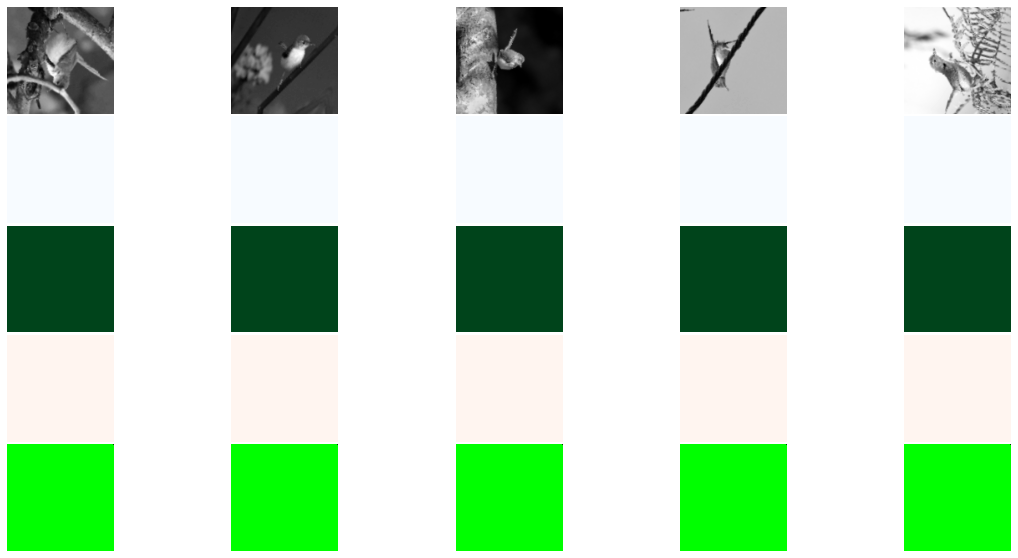

In [16]:
fig = showResult(model, train_ds.take(1))
plt.show()

In [17]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


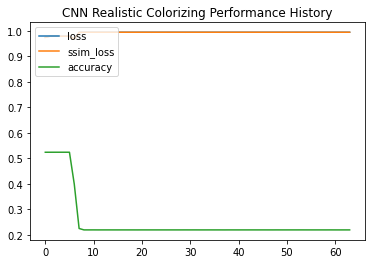

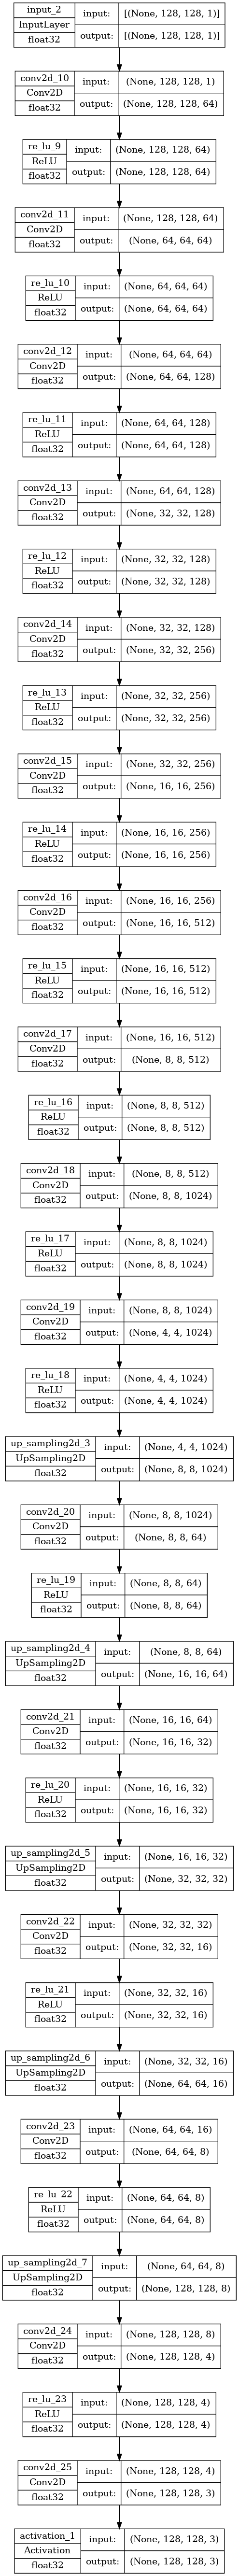

<Figure size 432x288 with 0 Axes>

In [18]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Realistic Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('{0}/cnn_{1}_model.png', root_dir, "Realistic Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
